In [1]:
# default_exp face_class_ver

In [2]:
import os
os.chdir('..')
os.getcwd()

'/home/ubuntu/hw2p2'

In [3]:
#hide
%load_ext autoreload
%autoreload 2

In [4]:
#export
# imports
import os
import pickle
import time
from functools import partial
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from PIL import Image
from sklearn.metrics import roc_auc_score

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

from hw2p2.models.resnet import ResNetN

#from hw2p2.datasets import FaceClassificationDataset, FaceVerificationDataset

In [5]:
#export
SIZE = 64

NO_TRANSF = [transforms.ToTensor(),
             transforms.Resize(SIZE)]

TRAIN_TRANSF = [transforms.Resize(SIZE),
                #transforms.RandomCrop(64),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.225, 0.226, 0.225],
                                     std=[0.5, 0.5, 0.5])]

VAL_TRANSF = [transforms.Resize(SIZE),
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.225, 0.226, 0.225],
                                   std=[0.5, 0.5, 0.5])]

# DATASETS

In [6]:
#export
class FaceClassificationDataset(Dataset):
    """
    """
    def __init__(self,
                 mode,
                 trans_list):

        # Assertions to avoid wrong inputs
        assert mode in ['train', 'val', 'test']
        assert mode == 'test' and n_classes == None or mode != 'test'

        # Directory setup
        data_dirs = {'train': './nbs/data/s1/train_data',
                     'val': './nbs/data/s1/val_data',
                     'test': './nbs/data/s1/test_data'}
        self.data_dir = data_dirs[mode]
        self.mode = mode
        self.trans_list = trans_list

        # Labels
        if (mode in ['train', 'val']):
            #self.labels = np.array([int(d) for d in os.listdir(self.data_dir)])
            self.labels = np.array([int(d) for d in os.listdir(self.data_dir) \
                                           for file in os.listdir(f'{self.data_dir}/{d}') if '.ipynb' not in file])
            
            self.X = np.array([str(file) for d in os.listdir(self.data_dir) \
                                           for file in os.listdir(f'{self.data_dir}/{d}') if '.ipynb' not in file])
            
            #self.labels = self.labels[:50_000]
            #self.X = self.X[:50_000]
        
        elif mode == 'test':
            self.labels = os.listdir(self.data_dir)
            self.labels = np.array([int(f.split('.')[0]) for f in self.labels])
            self.labels.sort(axis=0)

            self.map_files = []
            for l in self.labels:
                temp_ls = [(l, f) for f in \
                    os.listdir(os.path.join(self.data_dir, str(l)))]
                temp_ls = [(t[0], t[1]) for t in temp_ls]
                self.map_files.append(temp_ls)

            self.map_files = [t for sl in self.map_files for t in sl]
            self.labels = [t[0] for t in self.map_files]
            self.X = [t[1] for t in self.map_files]
   
    def __len__(self): 
            return len(self.X)

    def __getitem__(self, idx):
        preprocess = transforms.Compose(self.trans_list)
        
        image_path = os.path.join(self.data_dir, 
                                  str(self.labels[idx]), 
                                  self.X[idx])
        image_tensor = Image.open(image_path)
        image_tensor = preprocess(image_tensor)

        if self.mode == 'test': 
            return image_tensor
        else: 
            return image_tensor, self.labels[idx]

In [7]:
#export
class FaceVerificationDataset(Dataset):
    """
    """
    def __init__(self,
                 mode,
                 trans_list):

        # Assertions to avoid wrong inputs
        assert mode in ['val', 'test']
        assert mode == 'test' and sample == None or mode != 'test'

        # Directory setup
        pairs_dirs = {'val': './nbs/data/s2/verification_pairs_val.txt',
                     'test': './nbs/data/s2/verification_pairs_test.txt'}
        self.pairs_dir = pairs_dirs[mode]
        self.mode = mode
        self.trans_list = trans_list

        with open(self.pairs_dir) as f:
            self.pairs = [l.rstrip().split() for l in f]
   
    def __len__(self): 
        return len(self.pairs)

    def __getitem__(self, idx):
        preprocess = transforms.Compose(self.trans_list)
        
        image_tensor_0 = Image.open('./nbs/data/s2/' + self.pairs[idx][0])
        image_tensor_1 = Image.open('./nbs/data/s2/' + self.pairs[idx][1])
        
        image_tensor_0 = preprocess(image_tensor_0)
        image_tensor_1 = preprocess(image_tensor_1)
        
        if self.mode == 'test': 
            return image_tensor_0, image_tensor_1
        else: 
            return image_tensor_0, image_tensor_1, int(self.pairs[idx][2])

## Visualization of original dataset

batch_x.shape torch.Size([4, 3, 64, 64])
batch_y.shape torch.Size([4])


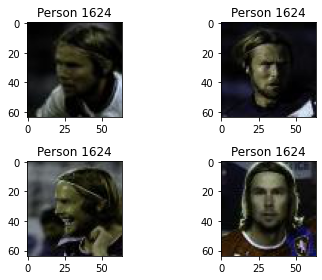

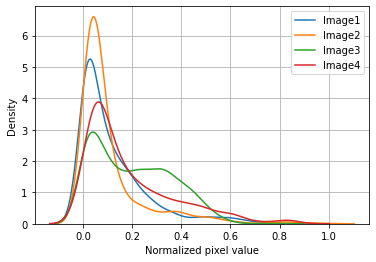

In [8]:
dataset = FaceClassificationDataset(trans_list=NO_TRANSF, mode='train')
dataloader = DataLoader(dataset, shuffle=False, batch_size=4, num_workers=0, drop_last=True)

batch_x, batch_y = next(iter(dataloader))
print("batch_x.shape", batch_x.shape)
print("batch_y.shape", batch_y.shape)

fig, axs = plt.subplots(2,2)
axs[0,0].imshow(batch_x[0,:,:,:].permute(1, 2, 0))
axs[0,0].set_title(f'Person {batch_y[0]}')

axs[0,1].imshow(batch_x[1,:,:,:].permute(1, 2, 0))
axs[0,1].set_title(f'Person {batch_y[1]}')

axs[1,0].imshow(batch_x[2,:,:,:].permute(1, 2, 0))
axs[1,0].set_title(f'Person {batch_y[2]}')

axs[1,1].imshow(batch_x[3,:,:,:].permute(1, 2, 0))
axs[1,1].set_title(f'Person {batch_y[3]}')
fig.tight_layout()
plt.savefig('./results/original_dataset.png')
plt.show()

pixels = batch_x.reshape(len(batch_x), -1)
sample = np.random.choice(range(pixels.shape[1]), 1000)

ax = sns.kdeplot(data=pixels[0, sample], label='Image1')
sns.kdeplot(data=pixels[1, sample], label='Image2')
sns.kdeplot(data=pixels[2, sample], label='Image3')
sns.kdeplot(data=pixels[3, sample], label='Image4')
plt.grid()
plt.legend()
ax.set(xlabel='Normalized pixel value')
plt.savefig('./results/original_distribution.png')

### Visualization of training dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch_x.shape torch.Size([4, 3, 64, 64])
batch_y.shape torch.Size([4])


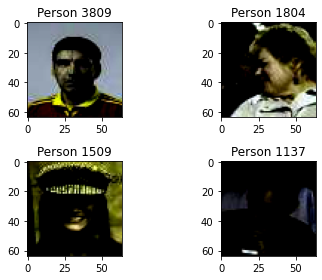

np.mean(pixels[3, sample]) tensor(0.2747)
np.mean(pixels[1, sample]) tensor(0.0248)
np.mean(pixels[2, sample]) tensor(-0.1264)
np.mean(pixels[3, sample]) tensor(-0.2746)


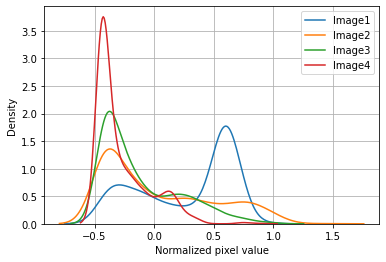

In [9]:
dataset = FaceClassificationDataset(trans_list=TRAIN_TRANSF, mode='val')
dataloader = DataLoader(dataset, shuffle=True, batch_size=4, num_workers=0, drop_last=True)

batch_x, batch_y = next(iter(dataloader))
print("batch_x.shape", batch_x.shape)
print("batch_y.shape", batch_y.shape)

fig, axs = plt.subplots(2,2)
axs[0,0].imshow(batch_x[0,:,:,:].permute(1, 2, 0))
axs[0,0].set_title(f'Person {batch_y[0]}')

axs[0,1].imshow(batch_x[1,:,:,:].permute(1, 2, 0))
axs[0,1].set_title(f'Person {batch_y[1]}')

axs[1,0].imshow(batch_x[2,:,:,:].permute(1, 2, 0))
axs[1,0].set_title(f'Person {batch_y[2]}')

axs[1,1].imshow(batch_x[3,:,:,:].permute(1, 2, 0))
axs[1,1].set_title(f'Person {batch_y[3]}')
fig.tight_layout()
plt.savefig('./results/train_dataset.png')
plt.show()

# Distribution plot
pixels = batch_x.reshape(len(batch_x), -1)
sample = np.random.choice(range(pixels.shape[1]), 1000)

print("np.mean(pixels[3, sample])", pixels[0, sample].mean())
print("np.mean(pixels[1, sample])", pixels[1, sample].mean())
print("np.mean(pixels[2, sample])", pixels[2, sample].mean())
print("np.mean(pixels[3, sample])", pixels[3, sample].mean())

ax = sns.kdeplot(data=pixels[0, sample], label='Image1')
sns.kdeplot(data=pixels[1, sample], label='Image2')
sns.kdeplot(data=pixels[2, sample], label='Image3')
sns.kdeplot(data=pixels[3, sample], label='Image4')
plt.grid()
plt.legend()
ax.set(xlabel='Normalized pixel value')
plt.savefig('./results/train_distribution.png')

## Check verification dataset

batch_x1.shape torch.Size([4, 3, 64, 64])
batch_x2.shape torch.Size([4, 3, 64, 64])
batch_y.shape torch.Size([4])


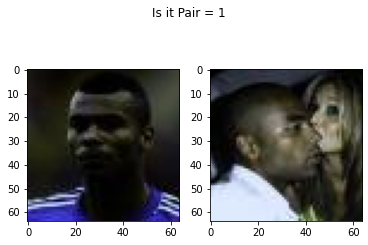

In [10]:
dataset = FaceVerificationDataset(trans_list=NO_TRANSF, mode='val')
dataloader = DataLoader(dataset, shuffle=True, batch_size=4, num_workers=0, drop_last=True)

batch_x1, batch_x2, batch_y = next(iter(dataloader))
print("batch_x1.shape", batch_x1.shape)
print("batch_x2.shape", batch_x2.shape)
print("batch_y.shape", batch_y.shape)

fig, axs = plt.subplots(1,2)
axs[0].imshow(batch_x1[0,:,:,:].permute(1, 2, 0))
axs[1].imshow(batch_x2[0,:,:,:].permute(1, 2, 0))
fig.suptitle(f'Is it Pair = {batch_y[0]}')
plt.show()

In [11]:
#export
def create_dataloaders(mc):
    num_workers = 8 if torch.cuda.is_available() else 0
    train_dataset = FaceClassificationDataset(trans_list=TRAIN_TRANSF, mode='train')
    clf_dataset   = FaceClassificationDataset(trans_list=VAL_TRANSF, mode='val')
    vrf_dataset   = FaceVerificationDataset(trans_list=VAL_TRANSF, mode='val')

    print(f'n_train: {len(train_dataset)}, n_clf: {len(clf_dataset)}, n_vrf: {len(vrf_dataset)}')

    train_loader = DataLoader(train_dataset, 
                              shuffle=True, 
                              batch_size=mc['batch_size'], 
                              num_workers=num_workers, 
                              pin_memory=torch.cuda.is_available(),
                              drop_last=True)
    
    clf_loader = DataLoader(clf_dataset,
                            shuffle=False, 
                            batch_size=2048,
                            num_workers=num_workers, 
                            pin_memory=torch.cuda.is_available(),
                            drop_last=True)
    
    vrf_loader = DataLoader(vrf_dataset, 
                            shuffle=False, 
                            batch_size=2048,
                            num_workers=num_workers, 
                            pin_memory=torch.cuda.is_available(),
                            drop_last=True)
    
    assert len(train_loader) > 0
    assert len(clf_loader) > 0
    assert len(vrf_loader) > 0
    
    return train_loader, clf_loader, vrf_loader

# RESNET

# HYPERPARAMETER OPTIMIZATION

In [12]:
#export
def fit_predict(mc, verbose, trials=None):
    
    assert mc['model'] in ['resnet18', 'resnet34', 'resnet50', 'mobilenet']
    
    train_loader, clf_loader, vrf_loader = create_dataloaders(mc)

    print(f'\nCurrent directory: {os.getcwd()}\n')
    now = datetime.now().strftime("%d-%m-%y_%H-%M-%S")
    print(now)

    start_time = time.time()
    print('='*26)
    print(pd.Series(mc))
    print('='*26+'\n')
    
    resnet_layers_dict = {'resnet18': 18, 
                          'resnet34': 34}
    resnet_n_layers = resnet_layers_dict[mc['model']]

    model = ResNetN(resnet_n_layers,
                    in_channels=mc['in_channels'],
                    n_classes=mc['n_classes'],
                    lr=mc['lr'],
                    lr_decay=mc['lr_decay'],
                    n_lr_decay_steps=mc['n_lr_decay_steps'],
                    center_loss = mc['center_loss'],
                    weight_decay = mc['weight_decay'],
                    lr_cl=mc['lr_cl'],
                    alpha_cl=mc['alpha_cl'],
                    n_epochs=mc['n_epochs'],
                    eval_steps=mc['eval_epochs'])

    model.fit(train_loader=train_loader, 
              val_c_loader=clf_loader,
              val_v_loader=vrf_loader)
    
    if trials is not None: 
        print("\n")
        print(" model.val_c_loss", model.val_c_loss)
        print("\n")
        results = {'loss':  model.val_c_loss,
                   'train_c_acc': model.train_c_acc,
                   'clf_loss': model.val_c_loss,
                   'clf_acc': model.val_c_acc,
                   'vrf_acc': model.val_v_acc,
                   'mc': mc,
                   'run_time': time.time()-start_time,
                   'trajectories': model.trajectories,
                   'time_stamp': now,
                   'status': STATUS_OK}
        return results
    else: 
        return model

In [13]:
#export
def main(max_evals=2):
    # Hyperparameters space
    space = {'model': hp.choice(label='model', options=['resnet18']),
             'in_channels': hp.choice(label='in_channels', options=[3]),
             'n_classes': hp.choice(label='n_classes', options=[4000]),
             'batch_size': scope.int(hp.choice(label='batch_size', options=[2048])),
             #'lr': hp.loguniform(label='lr', low=np.log(5e-3), high=np.log(5e-2)),
             'lr': hp.choice(label='lr', options=[0.005]),
             'lr_decay': hp.choice(label='lr_decay', options=[0.5]),
             'n_lr_decay_steps': hp.choice(label='n_lr_decay_steps', options=[2]),
             'center_loss': hp.choice(label='center_loss', options=[True]),
             'weight_decay': hp.choice(label='weight_decay', options=[0.0004]),
             #'lr_cl': hp.loguniform(label='lr_cl', low=np.log(5e-3), high=np.log(2e-1)),
             'lr_cl': hp.choice(label='lr_cl', options=[0.005]),
             'alpha_cl': hp.choice(label='alpha_cl', options=[0.01, 0.1, 1]),
             'n_epochs': hp.choice(label='n_epochs', options=[100]),
             'eval_epochs': scope.int(hp.choice(label='eval_epochs', options=[4])),
             'random_seed': scope.int(hp.quniform('random_seed', 1, 10, 1)),
             }

    # Hyperparameters search
    trials = Trials()
    fmin_objective = partial(fit_predict, trials=trials, verbose=True)
    fmin(fmin_objective, space=space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
    
    # Save output
    hyperopt_file = './nbs/results/trials.p'
    with open(hyperopt_file, "wb") as f:
        pickle.dump(trials, f)

In [14]:
os.getcwd()
# os.chdir('..')

'/home/ubuntu/hw2p2'

In [15]:
#export
if __name__ == "__main__":
    main(max_evals=2)

n_train: 380638, n_clf: 8000, n_vrf: 8805            
                                                     
Current directory: /home/ubuntu/hw2p2

18-03-21_22-02-32                                    
alpha_cl                   1                         
batch_size              2048
center_loss             True
eval_epochs                4
in_channels                3
lr                     0.005
lr_cl                  0.005
lr_decay                 0.5
model               resnet18
n_classes               4000
n_epochs                 100
n_lr_decay_steps           2
random_seed                7
weight_decay          0.0004
dtype: object

==============================Start Fitting==============================
  0%|          | 0/2 [00:52<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [8]:
os.getcwd()

'/home/ubuntu/hw2p2'

In [ ]:
import json

model_mc_file = './results/mc_17-03-21_23-28-42.json'
with open(model_mc_file) as f: mc = json.load(f)
model_mc_file = './results/res_dict_17-03-21_23-28-42.json'
with open(model_mc_file) as f: res = json.load(f)
model_file = './results/hw2p2_17-03-21_23-28-42.pth'

model = ResNetN(18,
                in_channels=mc['in_channels'],
                n_classes=mc['n_classes'],
                lr=mc['lr'],
                lr_decay=mc['lr_decay'],
                n_lr_decay_steps=mc['n_lr_decay_steps'],
                center_loss = mc['center_loss'],
                lr_cl=mc['lr_cl'],
                alpha_cl=mc['alpha_cl'],
                n_epochs=mc['n_epochs'],
                eval_steps=mc['eval_steps'])

model.model.load_state_dict(torch.load(model_file))

In [ ]:
print(res)
print(mc)

In [ ]:
model_mc_file = './results/mc_17-03-21_23-28-57.json'
with open(model_mc_file) as f: mc = json.load(f)
model_mc_file = './results/res_dict_17-03-21_23-28-57.json'
with open(model_mc_file) as f: res = json.load(f)
model_file = './results/hw2p2_17-03-21_23-28-57.pth'

model = ResNetN(18,
                in_channels=mc['in_channels'],
                n_classes=mc['n_classes'],
                lr=mc['lr'],
                lr_decay=mc['lr_decay'],
                n_lr_decay_steps=mc['n_lr_decay_steps'],
                center_loss = mc['center_loss'],
                lr_cl=mc['lr_cl'],
                alpha_cl=mc['alpha_cl'],
                n_epochs=mc['n_epochs'],
                eval_steps=mc['eval_steps'])

model.model.load_state_dict(torch.load(model_file))

<All keys matched successfully>

In [ ]:
print(res)
print(mc)

{'loss': -1.0, 'val_c_loss': -1, 'train_c_acc': 0.10276442307692307, 'val_c_acc': 0.125, 'val_v_acc': 0.47619047619047616, 'run_time': 14.389012336730957, 'trajectories': {'epoch': [0, 4], 'train_loss': [7.035186199041513, 5.624412055198963], 'train_c_acc': [0.09254807692307693, 0.10276442307692307], 'val_c_loss': [12.188202381134033, 12.305235862731934], 'val_c_acc': [0.125, 0.125], 'val_v_acc': [0.47619047619047616, 0.47619047619047616]}}
{'alpha_cl': 0.01, 'batch_size': 16, 'center_loss': True, 'eval_steps': 4, 'in_channels': 3, 'lr': 0.029865896744795523, 'lr_cl': 0.15374739504606688, 'lr_decay': 0.5, 'model': 'resnet18', 'n_classes': 20, 'n_epochs': 5, 'n_lr_decay_steps': 3}


In [8]:
arr = np.arange(10)
np.random.shuffle(arr)
arr

array([2, 4, 3, 1, 9, 5, 8, 0, 7, 6])